
Random Forest - Processing Dataset: diabetes.csv (Target: Outcome)

Results saved to random_forest_diabetes_results.csv
Dataset: diabetes.csv | Classifier: Random Forest

Regression Coefficients:
Entropy  Coefficient (β)
 H_data        31.545292
 H_pred         0.099277
H_error        -0.246238

Intercept (β₀): -28.50927
Model R² score: 0.59834
MSE: 0.00043
RMSE: 0.02079

Observed vs Predicted Accuracy:
 Index  Observed  Predicted  Difference
     0  0.724138   0.713940    0.010198
     1  0.701299   0.677356    0.023943
     2  0.703125   0.688008    0.015117
     3  0.692641   0.674682    0.017959
     4  0.624535   0.680028   -0.055493
     5  0.698276   0.767807   -0.069531
     6  0.766234   0.770323   -0.004089
     7  0.750000   0.758041   -0.008041
     8  0.709957   0.746169   -0.036212
     9  0.728625   0.740521   -0.011897
    10  0.784483   0.772958    0.011525
    11  0.759740   0.740512    0.019228
    12  0.744792   0.749496   -0.004704
    13  0.766234   0.746490    0

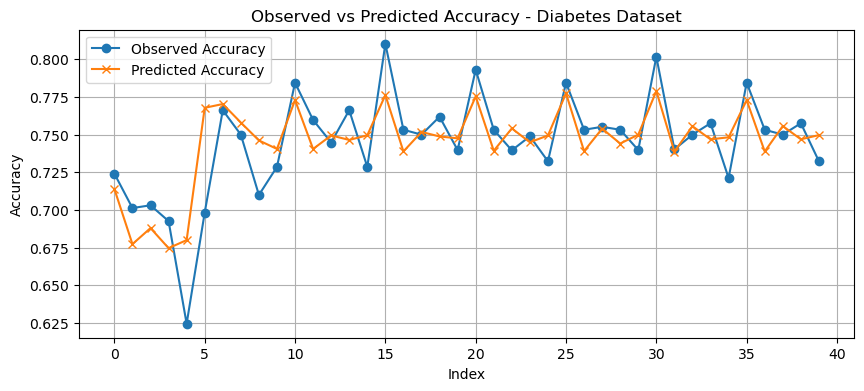

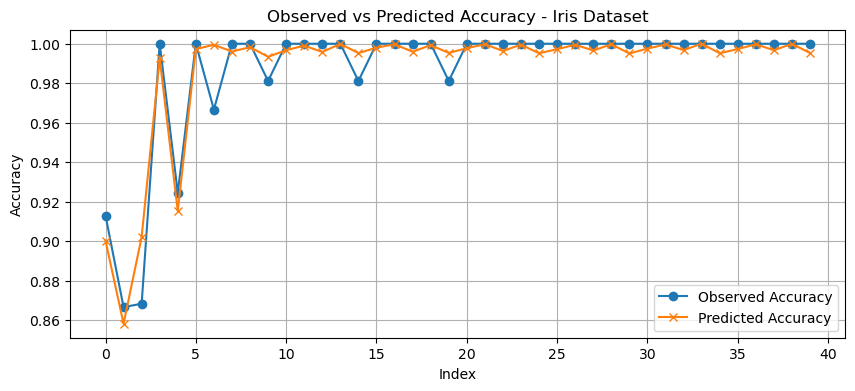

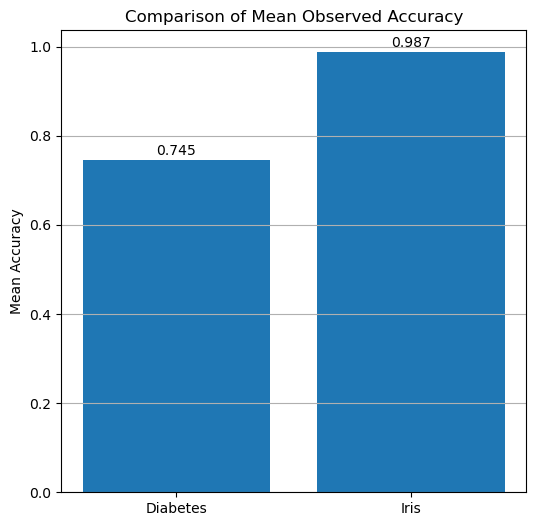

In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute entropies for Random Forest
def compute_entropies_and_accuracy(n_estimators, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, max_depth=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    probs = rf.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    # H_data: class distribution entropy
    class_probs = np.bincount(y_train) / len(y_train)
    H_data = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_error: entropy of misclassified true class distribution
    errors = y_test[y_test != y_pred]
    if len(errors) > 0:
        error_counts = np.bincount(errors, minlength=len(np.unique(y_train)))
        q = error_counts / np.sum(error_counts)
        q = q[q > 0]
        H_error = entropy(q, base=2)
    else:
        H_error = 0.0

    return H_data, H_pred, H_error, acc

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("iris.csv", "Species")
]

# Process each dataset with Random Forest
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Random Forest - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different n_estimators values
        records = []
        for n_est in [1, 10, 50, 100, 150, 200, 250, 300]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_data, H_pred, H_error, acc = compute_entropies_and_accuracy(n_est, test_size=split)
                records.append({
                    "n_estimators": n_est,
                    "split": split,
                    "H_data": H_data,
                    "H_pred": H_pred,
                    "H_error": H_error,
                    "Accuracy": acc
                })
        
        df = pd.DataFrame(records)

        output_filename = f"random_forest_{csv_file.replace('.csv','')}_results.csv"
        df.to_csv(output_filename, index=False)
        print(f"Results saved to {output_filename}")

        # Linear regression: Accuracy as function of entropies
        X_reg = df[["H_data", "H_pred", "H_error"]].values
        y_reg = df["Accuracy"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_data", "H_pred", "H_error"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Random Forest")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Accuracy:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with n_estimators and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Accuracy: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Accuracy: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# --- Diabetes dataset (Observed & Predicted) ---
obs_diabetes = [
0.724138,0.701299,0.703125,0.692641,0.624535,0.698276,0.766234,0.75,
0.709957,0.728625,0.784483,0.75974,0.744792,0.766234,0.728625,0.810345,
0.753247,0.75,0.761905,0.739777,0.793103,0.753247,0.739583,0.748918,
0.732342,0.784483,0.753247,0.755208,0.753247,0.739777,0.801724,0.74026,
0.75,0.757576,0.72119,0.784483,0.753247,0.75,0.757576,0.732342
]

pred_diabetes = [
0.71394,0.677356,0.688008,0.674682,0.680028,0.767807,0.770323,0.758041,
0.746169,0.740521,0.772958,0.740512,0.749496,0.74649,0.749574,0.776263,
0.738858,0.75178,0.748802,0.747566,0.775384,0.739311,0.754148,0.744951,
0.749465,0.7774,0.739067,0.754019,0.744109,0.749987,0.778944,0.738752,
0.75561,0.746888,0.748255,0.772881,0.738836,0.755708,0.746939,0.749696
]

# --- Iris dataset (Observed & Predicted) ---
obs_iris = [
0.913043,0.866667,0.868421,1.0,0.924528,1.0,0.966667,1.0,1.0,0.981132,
1.0,1.0,1.0,1.0,0.981132,1.0,1.0,1.0,1.0,0.981132,1.0,1.0,1.0,1.0,
1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
]

pred_iris = [
0.900338,0.858282,0.902167,0.992573,0.915305,0.997243,0.999461,0.99605,
0.998262,0.993376,0.996731,0.999031,0.995835,0.999908,0.99524,0.998017,
0.999719,0.995935,0.999274,0.995353,0.997725,0.999737,0.996347,0.999527,
0.995183,0.997233,0.999471,0.996575,0.999698,0.995057,0.997525,0.999639,
0.996781,0.999998,0.995181,0.997296,0.999715,0.996715,0.999921,0.9953
]

# Mean values
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)

# ==================================================
# 1️⃣ Plot: Observed vs Predicted - Diabetes Dataset
# ==================================================
plt.figure(figsize=(10,4))
plt.plot(obs_diabetes, label="Observed Accuracy", marker='o')
plt.plot(pred_diabetes, label="Predicted Accuracy", marker='x')
plt.title("Observed vs Predicted Accuracy - Diabetes Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# =============================================
# 2️⃣ Plot: Observed vs Predicted - Iris Dataset
# =============================================
plt.figure(figsize=(10,4))
plt.plot(obs_iris, label="Observed Accuracy", marker='o')
plt.plot(pred_iris, label="Predicted Accuracy", marker='x')
plt.title("Observed vs Predicted Accuracy - Iris Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ===============================================
# 3️⃣ Bar Plot: Mean Observed Accuracy Comparison
# ===============================================
plt.figure(figsize=(6,6))
bars = plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])

# Highlight bar tops with exact values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005,
             f"{yval:.3f}", ha='center', va='bottom', fontsize=10)

plt.title("Comparison of Mean Observed Accuracy")
plt.ylabel("Mean Accuracy")
plt.grid(axis='y')
plt.show()



SVM - Processing Dataset: diabetes.csv (Target: Outcome)

Results saved to svm_diabetes_results.csv
Dataset: diabetes.csv | Classifier: SVM

Regression Coefficients:
Entropy  Coefficient (β)
 H_data        15.453251
 H_pred        -0.432204
H_error         0.106115

Intercept (β₀): -13.46155
Model R² score: 0.65216
MSE: 0.00060
RMSE: 0.02454

Observed vs Predicted Accuracy:
 Index  Observed  Predicted  Difference
     0  0.655172   0.661128   -0.005956
     1  0.649351   0.642359    0.006992
     2  0.651042   0.660636   -0.009595
     3  0.649351   0.654063   -0.004713
     4  0.650558   0.640882    0.009675
     5  0.655172   0.662290   -0.007117
     6  0.649351   0.643622    0.005728
     7  0.651042   0.660792   -0.009750
     8  0.649351   0.655226   -0.005875
     9  0.650558   0.643103    0.007454
    10  0.758621   0.742164    0.016457
    11  0.714286   0.727071   -0.012785
    12  0.718750   0.739643   -0.020893
    13  0.727273   0.710878    0.016394
    14  0.724907   0.7

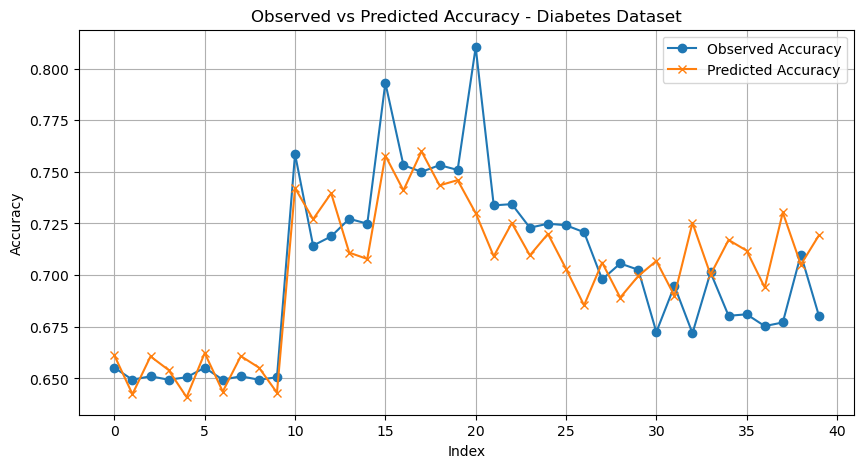

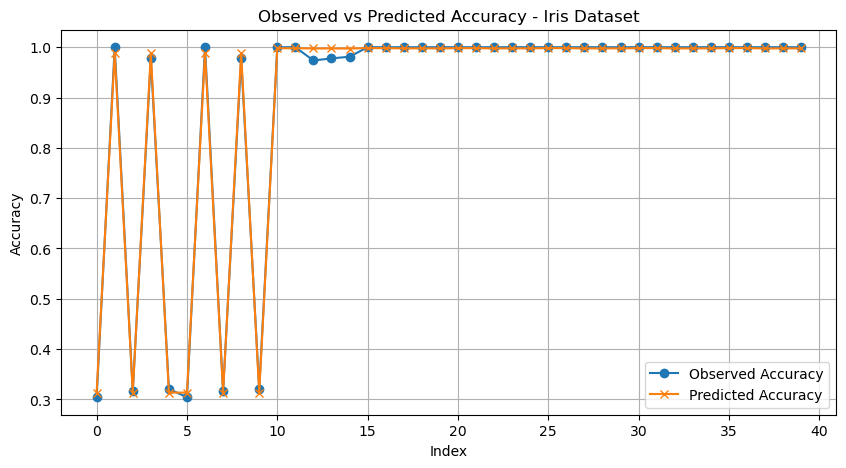

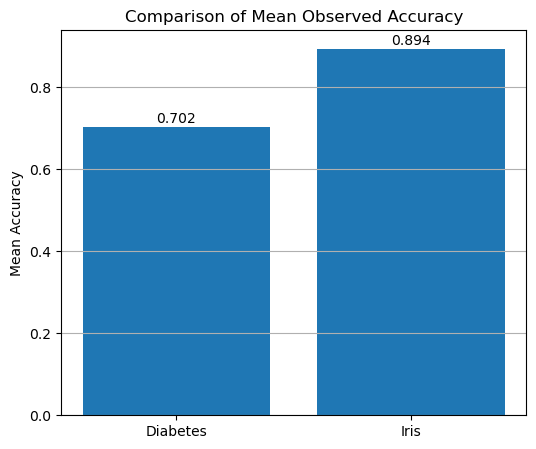

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import entropy
from sklearn.linear_model import LinearRegression

# Function to compute entropies for SVM
def compute_entropies_and_accuracy(C, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    svm = SVC(C=C, kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    probs = svm.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    # H_data: class distribution entropy
    class_probs = np.bincount(y_train) / len(y_train)
    H_data = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_error: entropy of misclassified true class distribution
    errors = y_test[y_test != y_pred]
    if len(errors) > 0:
        error_counts = np.bincount(errors, minlength=len(np.unique(y_train)))
        q = error_counts / np.sum(error_counts)
        q = q[q > 0]
        H_error = entropy(q, base=2)
    else:
        H_error = 0.0

    return H_data, H_pred, H_error, acc

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("iris.csv", "Species")
]

# Process each dataset with SVM
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"SVM - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)

        output_filename = f"svm_{csv_file.replace('.csv','')}_results.csv"
        df.to_csv(output_filename, index=False)
        print(f"Results saved to {output_filename}")
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different C values
        records = []
        for C in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_data, H_pred, H_error, acc = compute_entropies_and_accuracy(C, test_size=split)
                records.append({
                    "C": C,
                    "split": split,
                    "H_data": H_data,
                    "H_pred": H_pred,
                    "H_error": H_error,
                    "Accuracy": acc
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Accuracy as function of entropies
        X_reg = df[["H_data", "H_pred", "H_error"]].values
        y_reg = df["Accuracy"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_data", "H_pred", "H_error"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: SVM")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Accuracy:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with C and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Accuracy: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Accuracy: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ================================
# Diabetes Observed & Predicted
# ================================
obs_diabetes = [
0.655172,0.649351,0.651042,0.649351,0.650558,0.655172,0.649351,0.651042,
0.649351,0.650558,0.758621,0.714286,0.71875,0.727273,0.724907,0.793103,
0.753247,0.75,0.753247,0.750929,0.810345,0.733766,0.734375,0.722944,
0.724907,0.724138,0.720779,0.697917,0.705628,0.702602,0.672414,0.694805,
0.671875,0.701299,0.680297,0.681034,0.675325,0.677083,0.709957,0.680297
]

pred_diabetes = [
0.661128,0.642359,0.660636,0.654063,0.640882,0.66229,0.643622,0.660792,
0.655226,0.643103,0.742164,0.727071,0.739643,0.710878,0.707831,0.757863,
0.741003,0.759938,0.743445,0.745992,0.730006,0.709122,0.725213,0.709591,
0.719977,0.703081,0.685374,0.706078,0.689128,0.69957,0.706876,0.690036,
0.725289,0.700204,0.717037,0.711844,0.694037,0.730338,0.705081,0.719285
]


# ================================
# Iris Observed & Predicted
# ================================
obs_iris = [
0.304348,1.0,0.315789,0.977778,0.320755,0.304348,1.0,0.315789,
0.977778,0.320755,1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,1.0,
1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,
1.0,1.0,1.0,1.0,1.0,1.0
]

pred_iris = [
0.313657,0.988305,0.313612,0.988289,0.31361,0.313559,0.988292,0.313717,
0.988323,0.313628,0.997943,0.997941,0.99749,0.997485,0.99742,0.998196,
0.998183,0.997642,0.997789,0.99763,0.998141,0.99819,0.99757,0.997761,
0.997668,0.998157,0.998232,0.997531,0.997739,0.997638,0.998157,0.998232,
0.997531,0.997739,0.997638,0.998157,0.998232,0.997531,0.997739,0.997638
]


# ================================
# Compute means
# ================================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)


# ====================================================
# 1️⃣ Plot: Observed vs Predicted — Diabetes Dataset
# ====================================================
plt.figure(figsize=(10,5))

# Plot lines
plt.plot(obs_diabetes, marker='o', label="Observed Accuracy")
plt.plot(pred_diabetes, marker='x', label="Predicted Accuracy")

plt.title("Observed vs Predicted Accuracy - Diabetes Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# ==================================================
# 2️⃣ Plot: Observed vs Predicted — Iris Dataset
# ==================================================
plt.figure(figsize=(10,5))

plt.plot(obs_iris, marker='o', label="Observed Accuracy")
plt.plot(pred_iris, marker='x', label="Predicted Accuracy")

plt.title("Observed vs Predicted Accuracy - Iris Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# ==================================================
# 3️⃣ Bar Plot: Comparison of Mean Observed Accuracy
# ==================================================
plt.figure(figsize=(6,5))

plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])

# Highlight bar values
plt.text(0, mean_obs_diabetes + 0.01, f"{mean_obs_diabetes:.3f}", ha='center')
plt.text(1, mean_obs_iris + 0.01, f"{mean_obs_iris:.3f}", ha='center')

plt.title("Comparison of Mean Observed Accuracy")
plt.ylabel("Mean Accuracy")
plt.grid(axis='y')
plt.show()


KNN - Processing Dataset: diabetes.csv (Target: Outcome)

Results saved to knn_diabetes_results.csv
Dataset: diabetes.csv | Classifier: KNN

Regression Coefficients:
Entropy  Coefficient (β)
 H_data         9.699286
 H_pred         0.061210
H_error        -0.122812

Intercept (β₀): -8.23101
Model R² score: 0.44645
MSE: 0.00038
RMSE: 0.01957

Observed vs Predicted Accuracy:
 Index  Observed  Predicted  Difference
     0  0.689655   0.703312   -0.013657
     1  0.707792   0.693603    0.014190
     2  0.703125   0.697598    0.005527
     3  0.731602   0.690920    0.040682
     4  0.706320   0.694991    0.011329
     5  0.715517   0.731013   -0.015496
     6  0.694805   0.720579   -0.025774
     7  0.692708   0.724162   -0.031453
     8  0.701299   0.721534   -0.020235
     9  0.684015   0.721648   -0.037633
    10  0.715517   0.737740   -0.022223
    11  0.701299   0.727502   -0.026204
    12  0.708333   0.730685   -0.022351
    13  0.714286   0.727863   -0.013577
    14  0.721190   0.73

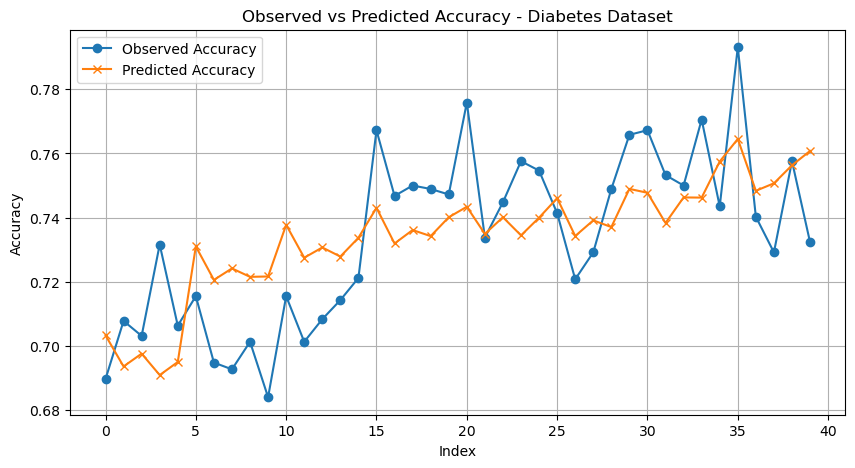

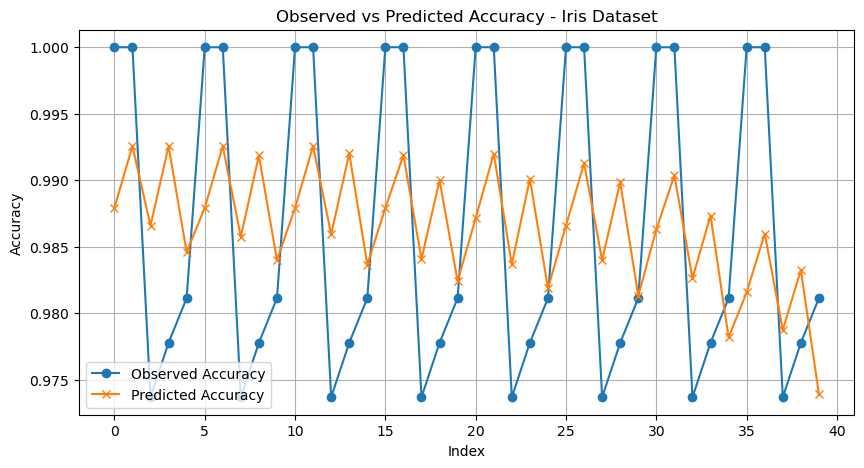

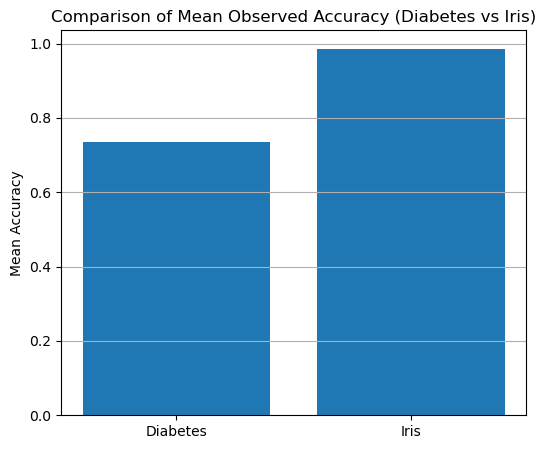

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import entropy

# Function to compute entropies for KNN
def compute_entropies_and_accuracy(n_neighbors, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    probs = knn.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    # H_data: class distribution entropy
    class_probs = np.bincount(y_train) / len(y_train)
    H_data = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_error: entropy of misclassified true class distribution
    errors = y_test[y_test != y_pred]
    if len(errors) > 0:
        error_counts = np.bincount(errors, minlength=len(np.unique(y_train)))
        q = error_counts / np.sum(error_counts)
        q = q[q > 0]
        H_error = entropy(q, base=2)
    else:
        H_error = 0.0

    return H_data, H_pred, H_error, acc

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("iris.csv", "Species")
]

# Process each dataset with KNN
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"KNN - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)
        
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different k (n_neighbors) values
        records = []
        for k in [1, 3, 5, 7, 9, 11, 15, 21]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_data, H_pred, H_error, acc = compute_entropies_and_accuracy(k, test_size=split)
                records.append({
                    "k": k,
                    "split": split,
                    "H_data": H_data,
                    "H_pred": H_pred,
                    "H_error": H_error,
                    "Accuracy": acc
                })
        
        df = pd.DataFrame(records)

        output_filename = f"knn_{csv_file.replace('.csv','')}_results.csv"
        df.to_csv(output_filename, index=False)
        print(f"Results saved to {output_filename}")
        
        # Linear regression: Accuracy as function of entropies
        X_reg = df[["H_data", "H_pred", "H_error"]].values
        y_reg = df["Accuracy"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_data", "H_pred", "H_error"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: KNN")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Accuracy:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with k and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Accuracy: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Accuracy: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ================================
# Diabetes Observed & Predicted
# ================================
obs_diabetes = [
0.689655,0.707792,0.703125,0.731602,0.706320,0.715517,0.694805,0.692708,
0.701299,0.684015,0.715517,0.701299,0.708333,0.714286,0.721190,0.767241,
0.746753,0.750000,0.748918,0.747212,0.775862,0.733766,0.744792,0.757576,
0.754647,0.741379,0.720779,0.729167,0.748918,0.765799,0.767241,0.753247,
0.750000,0.770563,0.743494,0.793103,0.740260,0.729167,0.757576,0.732342
]

pred_diabetes = [
0.703312,0.693603,0.697598,0.690920,0.694991,0.731013,0.720579,0.724162,
0.721534,0.721648,0.737740,0.727502,0.730685,0.727863,0.733704,0.743051,
0.731930,0.736120,0.734230,0.740105,0.743377,0.734922,0.740110,0.734457,
0.739972,0.746061,0.734258,0.739135,0.737049,0.748947,0.747734,0.738314,
0.746288,0.746231,0.757478,0.764510,0.748356,0.750685,0.756307,0.760781
]


# ================================
# Iris Observed & Predicted
# ================================
obs_iris = [
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132
]

pred_iris = [
0.987913,0.992565,0.986586,0.992565,0.984597,0.987913,0.992565,0.985751,
0.991860,0.983999,0.987913,0.992565,0.985929,0.992011,0.983656,0.987913,
0.991883,0.984076,0.989991,0.982412,0.987157,0.991985,0.983683,0.990114,
0.981860,0.986593,0.991271,0.983996,0.989853,0.981298,0.986298,0.990380,
0.982624,0.987347,0.978182,0.981568,0.985982,0.978740,0.983261,0.973896
]


# ================================
# Mean Observed Accuracy
# ================================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)


# ====================================================
# 1️⃣ Plot: Observed vs Predicted — Diabetes Dataset
# ====================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes, label="Observed Accuracy", marker='o')
plt.plot(pred_diabetes, label="Predicted Accuracy", marker='x')
plt.title("Observed vs Predicted Accuracy - Diabetes Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# ==================================================
# 2️⃣ Plot: Observed vs Predicted — Iris Dataset
# ==================================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris, label="Observed Accuracy", marker='o')
plt.plot(pred_iris, label="Predicted Accuracy", marker='x')
plt.title("Observed vs Predicted Accuracy - Iris Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


# ==================================================
# 3️⃣ Bar Plot: Comparison of Mean Observed Accuracy
# ==================================================
plt.figure(figsize=(6,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])
plt.title("Comparison of Mean Observed Accuracy (Diabetes vs Iris)")
plt.ylabel("Mean Accuracy")
plt.grid(axis='y')
plt.show()



Logistic Regression - Processing Dataset: diabetes.csv (Target: Outcome)

Results saved to logreg_diabetes_results.csv
Dataset: diabetes.csv | Classifier: Logistic Regression

Regression Coefficients:
Entropy  Coefficient (β)
 H_data        27.414188
 H_pred         0.694759
H_error        -0.677747

Intercept (β₀): -24.65428
Model R² score: 0.73312
MSE: 0.00003
RMSE: 0.00581

Observed vs Predicted Accuracy:
 Index  Observed  Predicted  Difference
     0  0.741379   0.736679    0.004701
     1  0.714286   0.717042   -0.002756
     2  0.734375   0.744507   -0.010132
     3  0.744589   0.739295    0.005294
     4  0.743494   0.740601    0.002894
     5  0.741379   0.736679    0.004701
     6  0.714286   0.717042   -0.002756
     7  0.734375   0.744507   -0.010132
     8  0.744589   0.739295    0.005294
     9  0.743494   0.740601    0.002894
    10  0.741379   0.736679    0.004701
    11  0.714286   0.717042   -0.002756
    12  0.734375   0.744507   -0.010132
    13  0.744589   0.739295

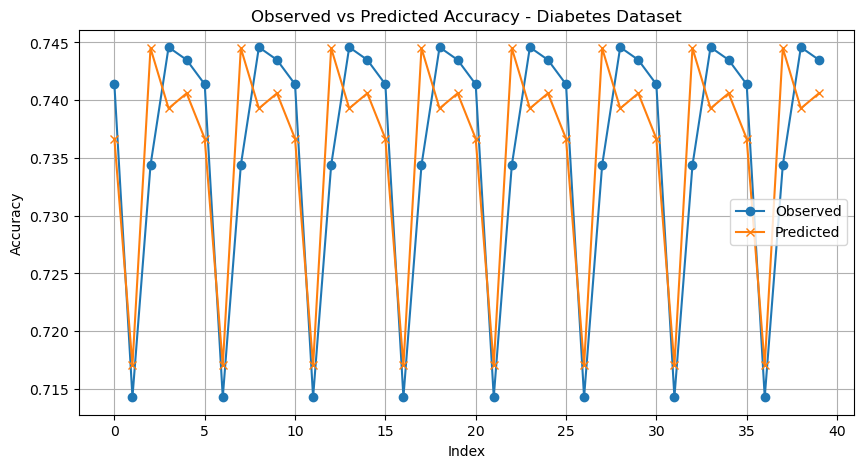

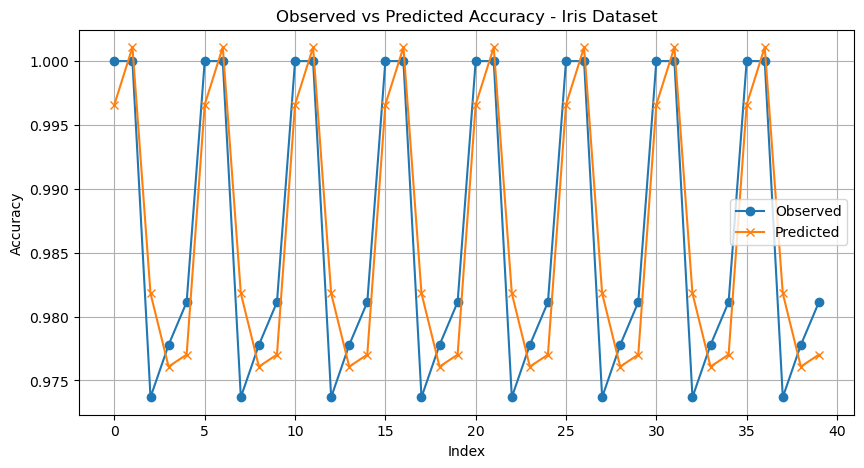

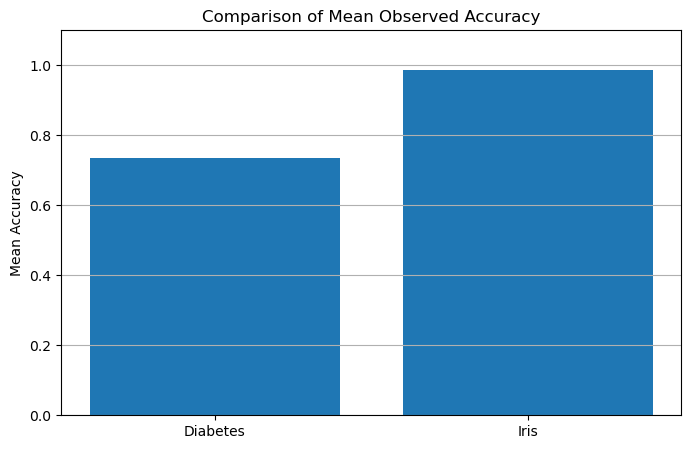

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import entropy

# Function to compute entropies for Logistic Regression
def compute_entropies_and_accuracy(max_iter, test_size, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    lr = LogisticRegression(max_iter=max_iter, solver='lbfgs', random_state=42)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    probs = lr.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)

    # H_data: class distribution entropy
    class_probs = np.bincount(y_train) / len(y_train)
    H_data = entropy(class_probs, base=2)

    # H_pred: mean entropy of predicted probability distribution
    H_pred = np.mean([entropy(p, base=2) for p in probs])

    # H_error: entropy of misclassified true class distribution
    errors = y_test[y_test != y_pred]
    if len(errors) > 0:
        error_counts = np.bincount(errors, minlength=len(np.unique(y_train)))
        q = error_counts / np.sum(error_counts)
        q = q[q > 0]
        H_error = entropy(q, base=2)
    else:
        H_error = 0.0

    return H_data, H_pred, H_error, acc

# Dataset configurations
datasets_config = [
    ("diabetes.csv", "Outcome"),
    ("iris.csv", "Species")
]

# Process each dataset with Logistic Regression
for csv_file, target_col in datasets_config:
    print(f"\n{'='*100}")
    print(f"Logistic Regression - Processing Dataset: {csv_file} (Target: {target_col})")
    print(f"{'='*100}\n")
    
    try:
        # Load dataset
        data = pd.read_csv(csv_file)

        output_filename = f"logreg_{csv_file.replace('.csv','')}_results.csv"
        df.to_csv(output_filename, index=False)
        print(f"Results saved to {output_filename}")
        # Drop non-numeric and irrelevant columns
        data = data.drop(columns=['PassengerId', 'Name', 'Ticket'], errors='ignore')
        
        # Drop rows with missing values
        data = data.dropna()
        
        # Encode categorical columns
        for col in data.select_dtypes(include=['object']).columns:
            if col != target_col:
                le = LabelEncoder()
                data[col] = le.fit_transform(data[col].astype(str))
        
        X = data.drop(columns=[target_col]).values
        
        y = data[target_col].values
        le = LabelEncoder()
        y = le.fit_transform(y)
        
        # Run multiple configurations with different max_iter values
        records = []
        for max_iter in [100, 200, 500, 1000, 1500, 2000, 3000, 5000]:
            for split in [0.15, 0.2, 0.25, 0.3, 0.35]:
                H_data, H_pred, H_error, acc = compute_entropies_and_accuracy(max_iter, test_size=split)
                records.append({
                    "max_iter": max_iter,
                    "split": split,
                    "H_data": H_data,
                    "H_pred": H_pred,
                    "H_error": H_error,
                    "Accuracy": acc
                })
        
        df = pd.DataFrame(records)
        
        # Linear regression: Accuracy as function of entropies
        X_reg = df[["H_data", "H_pred", "H_error"]].values
        y_reg = df["Accuracy"].values
        
        model = LinearRegression().fit(X_reg, y_reg)
        y_pred_reg = model.predict(X_reg)
        
        # Coefficients
        coeffs = pd.DataFrame({
            "Entropy": ["H_data", "H_pred", "H_error"],
            "Coefficient (β)": model.coef_
        })
        
        # Compute MSE and RMSE
        mse = mean_squared_error(y_reg, y_pred_reg)
        rmse = np.sqrt(mse)
        
        print(f"Dataset: {csv_file} | Classifier: Logistic Regression")
        print("\nRegression Coefficients:")
        print(coeffs.to_string(index=False))
        print(f"\nIntercept (β₀): {model.intercept_:.5f}")
        print(f"Model R² score: {model.score(X_reg, y_reg):.5f}")
        print(f"MSE: {mse:.5f}")
        print(f"RMSE: {rmse:.5f}")
        
        print(f"\nObserved vs Predicted Accuracy:")
        obs_pred_df = pd.DataFrame({
            "Index": range(len(y_reg)),
            "Observed": np.round(y_reg, 6),
            "Predicted": np.round(y_pred_reg, 6),
            "Difference": np.round(y_reg - y_pred_reg, 6)
        })
        print(obs_pred_df.to_string(index=False))
        
        print(f"\nResults Table (with max_iter and split variations):")
        print(df.to_markdown(index=False, floatfmt=".3f"))
        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Mean Observed Accuracy: {np.mean(y_reg):.6f}")
        print(f"Mean Predicted Accuracy: {np.mean(y_pred_reg):.6f}")
        print(f"Mean Difference (Obs - Pred): {np.mean(y_reg - y_pred_reg):.6f}")
        
    except Exception as e:
        print(f"Error processing {csv_file}: {str(e)}")

import matplotlib.pyplot as plt

# ============================
# 📌 Diabetes Observed & Predicted
# ============================
obs_diabetes = [
0.741379,0.714286,0.734375,0.744589,0.743494,0.741379,0.714286,0.734375,
0.744589,0.743494,0.741379,0.714286,0.734375,0.744589,0.743494,0.741379,
0.714286,0.734375,0.744589,0.743494,0.741379,0.714286,0.734375,0.744589,
0.743494,0.741379,0.714286,0.734375,0.744589,0.743494,0.741379,0.714286,
0.734375,0.744589,0.743494,0.741379,0.714286,0.734375,0.744589,0.743494
]

pred_diabetes = [
0.736679,0.717042,0.744507,0.739295,0.740601,0.736679,0.717042,0.744507,
0.739295,0.740601,0.736679,0.717042,0.744507,0.739295,0.740601,0.736679,
0.717042,0.744507,0.739295,0.740601,0.736679,0.717042,0.744507,0.739295,
0.740601,0.736679,0.717042,0.744507,0.739295,0.740601,0.736679,0.717042,
0.744507,0.739295,0.740601,0.736679,0.717042,0.744507,0.739295,0.740601
]


# ============================
# 📌 Iris Observed & Predicted
# ============================
obs_iris = [
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132,
1.0,1.0,0.973684,0.977778,0.981132,1.0,1.0,0.973684,0.977778,0.981132
]

pred_iris = [
0.996591,1.001086,0.981816,0.976081,0.977020,0.996591,1.001086,0.981816,
0.976081,0.977020,0.996591,1.001086,0.981816,0.976081,0.977020,0.996591,
1.001086,0.981816,0.976081,0.977020,0.996591,1.001086,0.981816,0.976081,
0.977020,0.996591,1.001086,0.981816,0.976081,0.977020,0.996591,1.001086,
0.981816,0.976081,0.977020,0.996591,1.001086,0.981816,0.976081,0.977020
]


# ============================
# 📌 Mean Accuracies
# ============================
mean_obs_diabetes = sum(obs_diabetes) / len(obs_diabetes)
mean_obs_iris = sum(obs_iris) / len(obs_iris)

# ==================================================
# 1️⃣ Plot: Observed vs Predicted - Diabetes Dataset
# ==================================================
plt.figure(figsize=(10,5))
plt.plot(obs_diabetes, marker='o')
plt.plot(pred_diabetes, marker='x')
plt.title("Observed vs Predicted Accuracy - Diabetes Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend(["Observed", "Predicted"])
plt.grid(True)
plt.show()

# =============================================
# 2️⃣ Plot: Observed vs Predicted - Iris Dataset
# =============================================
plt.figure(figsize=(10,5))
plt.plot(obs_iris, marker='o')
plt.plot(pred_iris, marker='x')
plt.title("Observed vs Predicted Accuracy - Iris Dataset")
plt.xlabel("Index")
plt.ylabel("Accuracy")
plt.legend(["Observed", "Predicted"])
plt.grid(True)
plt.show()

# ===============================================
# 3️⃣ Bar Plot: Mean Observed Accuracy Comparison
# ===============================================
plt.figure(figsize=(8,5))
plt.bar(["Diabetes", "Iris"], [mean_obs_diabetes, mean_obs_iris])
plt.title("Comparison of Mean Observed Accuracy")
plt.ylabel("Mean Accuracy")
plt.ylim(0, 1.1)
plt.grid(axis='y')
plt.show()
